<a href="https://colab.research.google.com/github/AayushiChoudhary01/NLP-abstract-sentence-classification/blob/main/abstract_sentence_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalAveragePooling1D, GlobalMaxPool1D, Bidirectional, LSTM, Concatenate, Dropout
import numpy as np
from tensorflow.data import Dataset
from tensorflow.keras import Model
import string
from tensorflow.keras.utils import plot_model



## Downloading the data

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 37.58 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [4]:
data_directory = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
import os
filenames = [data_directory + filename for filename in os.listdir(data_directory)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [6]:
def read_lines(filepath):
 with open(filepath,"r") as f:
  return f.readlines()

In [7]:
train_sentences = read_lines(data_directory + "train.txt")

In [8]:
train_sentences[:15]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

## Preprocessing & Visualizing the data

In [9]:
def preprocess_text_with_line_numbers(filepath):
  input_sentences = read_lines(filepath)
  abstract_lines = ""
  abstract_samples = []

  for line in input_sentences:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
       line_data = {}
       target_text_split = abstract_line.split("\t")
       line_data["target"] = target_text_split[0]
       line_data["text"] = target_text_split[1].lower()
       line_data["line_number"]= abstract_line_number
       line_data["total_lines"] = len(abstract_line_split)-1
       abstract_samples.append(line_data)
    else:
     abstract_lines+=line

  return abstract_samples

In [10]:
training_set = preprocess_text_with_line_numbers(data_directory + "train.txt")
validation_set = preprocess_text_with_line_numbers(data_directory + "dev.txt")
test_set = preprocess_text_with_line_numbers(data_directory + "test.txt")

In [11]:
print(len(training_set))
print(len(validation_set))
print(len(test_set))

180040
30212
30135


In [12]:
training_set[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [13]:
train_df = pd.DataFrame(training_set)
validation_df = pd.DataFrame(validation_set)
test_df = pd.DataFrame(test_set)

In [14]:

train_df[:10]

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [15]:
labels = train_df.target.value_counts()
labels_df = pd.DataFrame(labels)
labels_df

,target
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<BarContainer object of 5 artists>

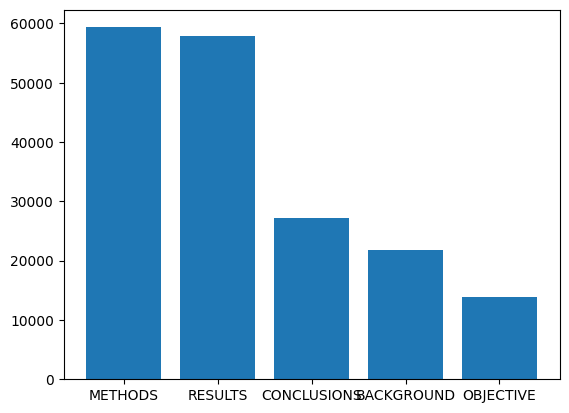

In [16]:
plt.bar(labels_df.index, labels_df['target'])

In [17]:
train_sentences = train_df["text"].tolist()
validation_sentences = validation_df["text"].tolist()
test_sentences = test_df["text"].tolist()

### Converting labels into numeric format

###One Hot encoded labels

In [18]:
# one hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot =one_hot_encoder.transform(validation_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [19]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(validation_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [20]:
len(label_encoder.classes_)


5

In [21]:
classes = label_encoder.classes_
print(len(classes))
print(classes)

5
['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


In [22]:
# scikit learn machine learning map

## Building a baseline model

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [24]:
base_model = Pipeline([("tf-idf", TfidfVectorizer()),
                    ("clf",MultinomialNB())
                    ])

In [25]:
base_model.fit(X= train_sentences, y = train_labels_encoded);

In [26]:
base_model.score(X= validation_sentences,
                 y= val_labels_encoded)

0.7218323844829869

In [27]:
base_model_predictions = base_model.predict(validation_sentences)
base_model_predictions

array([4, 1, 3, ..., 4, 4, 1])

In [28]:
def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [29]:
base_model_results= calculate_results(val_labels_encoded, base_model_predictions)
print(base_model_results)

{'accuracy': 72.1832384482987, 'precision': 0.7186466952323352, 'recall': 0.7218323844829869, 'f1': 0.6989250353450294}


##Preparing data for deep learning models


In [30]:

sen_length = [len(sentence.split()) for sentence in train_sentences]
average_sen_length = np.mean(sen_length)
print(average_sen_length)

26.338269273494777


In [31]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

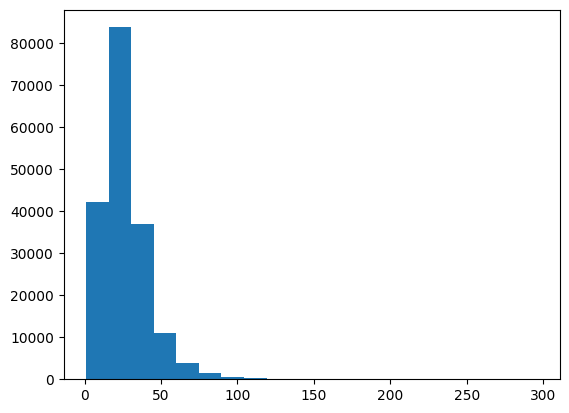

In [32]:
plt.hist(sen_length, bins=20)

In [33]:
max(sen_length)

296

## Text Vectorization layer
information taken from the paper:-
max features(vocab size):-68k

In [34]:
output_seq_length = int(np.percentile(sen_length, 95))
output_seq_length

55

In [35]:
from tensorflow.keras.layers import TextVectorization
max_tokens= 68000
text_vectorizer = TextVectorization(max_tokens= max_tokens,
                                    standardize= "lower_and_strip_punctuation",
                                    split= "whitespace",
                                    ngrams= None,
                                    output_mode= 'int',
                                    output_sequence_length= output_seq_length,
                                    pad_to_max_tokens= True)

In [36]:
text_vectorizer.adapt(train_sentences)

In [37]:
sen = train_sentences[0]
print(sen)
print(len(sen.split()))
vectorized_sen = text_vectorizer([sen])
print(f"sentence after vectorization(before embedding): {text_vectorizer([sen])}")

to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .
49
sentence after vectorization(before embedding): [[   6  331    2   79    4   53    4  161 1127  217 2535    5  557   65
  1584    3  670 5559  636    5    2  654 1137    3  180    2   70  495
    36  781   15   53    5  350  266    7  362    6  289  517 1430 1743
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [38]:
text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(text_vocab)}")
print(f"Most common words in vocab: {text_vocab[:5]}")
print(f"Least common words in vocab: {text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


## Creating embedding

In [39]:
from tensorflow.keras.layers import Embedding
embedding = Embedding(input_dim = len(text_vocab),
                      embeddings_initializer = "uniform",
                      mask_zero = True,
                      output_dim = 128)

In [40]:
print(f"sentence after embedding: {embedding(vectorized_sen)}")
embedded_sen = embedding(vectorized_sen)

sentence after embedding: [[[-0.02977158  0.04603061  0.01395993 ... -0.02648634 -0.02440267
   -0.01046491]
  [ 0.02532126  0.01429233  0.02016011 ... -0.03320946  0.03804718
    0.04598543]
  [-0.01285602  0.02369124  0.00339581 ...  0.0177015  -0.03616555
   -0.04716478]
  ...
  [ 0.04828406 -0.02275862 -0.00374055 ... -0.00474081  0.02149406
    0.04387972]
  [ 0.04828406 -0.02275862 -0.00374055 ... -0.00474081  0.02149406
    0.04387972]
  [ 0.04828406 -0.02275862 -0.00374055 ... -0.00474081  0.02149406
    0.04387972]]]


In [41]:
print(embedded_sen.shape)

(1, 55, 128)


##Better Performance with tf.data API
step 1:- Turning our data into tensorflow datasets
step2:- Turning tensorflow datasets into prefetching datasets

In [42]:

#step1
train_dataset = Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = Dataset.from_tensor_slices((validation_sentences, val_labels_one_hot))
test_dataset = Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [43]:

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1:- Conv1D with token embeddings

In [44]:
input_data = Input(shape=(1,), dtype= tf.string)
vectors = text_vectorizer(input_data)
token_embed = embedding(vectors)
x = Conv1D(64, kernel_size= 5, activation= "relu", padding ="same")(token_embed)
x = GlobalAveragePooling1D()(x)
output_data = Dense(len(classes), activation = "softmax")(x)
model_1 = Model(inputs = [input_data], outputs = [output_data], name = "model_1")

In [45]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 55, 128)           8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 5)                 325 

In [46]:
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [47]:
len_train_dataset = len(train_dataset)
len_val_dataset = len(val_dataset)

In [48]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len_train_dataset),
                              epochs = 3,
                              validation_data= val_dataset,
                              validation_steps = int(0.1*len_val_dataset))

Epoch 1/3
562/562 [==============================] - 21s 31ms/step - loss: 0.9092 - accuracy: 0.6380 - val_loss: 0.6846 - val_accuracy: 0.7397
Epoch 2/3
562/562 [==============================] - 5s 10ms/step - loss: 0.6567 - accuracy: 0.7557 - val_loss: 0.6275 - val_accuracy: 0.7743
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6178 - accuracy: 0.7726 - val_loss: 0.5990 - val_accuracy: 0.7796


In [49]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6006 - accuracy: 0.7859


[0.6006271839141846, 0.7858797907829285]

In [50]:
model_1_predprob = model_1.predict(val_dataset)
print(model_1_predprob)
print(model_1_predprob.shape)

945/945 [==============================] - 2s 2ms/step
[[4.5306936e-01 1.5159233e-01 8.0600023e-02 2.8290042e-01 3.1837851e-02]
 [4.6607780e-01 2.9082248e-01 1.2692921e-02 2.2165783e-01 8.7490818e-03]
 [1.5557523e-01 5.7610869e-03 1.7461409e-03 8.3689576e-01 2.1844036e-05]
 ...
 [3.5715227e-06 4.7254973e-04 5.1601639e-04 3.8559042e-06 9.9900407e-01]
 [5.0467297e-02 4.6808964e-01 9.3176924e-02 5.9213698e-02 3.2905236e-01]
 [1.5814440e-01 6.8084985e-01 3.5305023e-02 4.6417616e-02 7.9283088e-02]]
(30212, 5)


In [51]:
model_1_pred = tf.argmax(model_1_predprob, axis =1)

In [52]:
print(model_1_pred)

tf.Tensor([0 0 3 ... 4 1 1], shape=(30212,), dtype=int64)


In [53]:
Results_model_1 = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_pred)

In [54]:
print(Results_model_1)

{'accuracy': 78.58797828677346, 'precision': 0.7824102389993751, 'recall': 0.7858797828677346, 'f1': 0.7833405361137926}


##Model 2 : Feature Extraction with pretrained token embeddings
may check out:-huggingface.co/models


In [55]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [56]:
print(f"sentence before embedding layer: {train_sentences[0]}")
embedded_sentence = tf_hub_embedding_layer([train_sentences[0]])
print(f"sentence after embedding : {embedded_sentence}")

sentence before embedding layer: to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .
sentence after embedding : [[-4.90380339e-02  5.24623394e-02  3.95998619e-02 -6.31776527e-02
  -7.30676949e-02  6.28731474e-02  3.52799073e-02 -6.18203953e-02
   5.71083128e-02  4.63245437e-02  7.16570467e-02  2.51985993e-03
  -9.52070300e-03  6.51001697e-03  3.80008928e-02  3.74653973e-02
  -7.96469301e-02  6.41185641e-02  3.50537635e-02 -3.88272963e-02
   1.50759863e-02 -1.20223081e-02  1.47859231e-02 -2.70261355e-02
   1.51410606e-02  5.35054170e-02 -6.14336226e-03 -3.47358286e-02
  -7.48624578e-02  2.86218990e-03 -5.25581762e-02  7.89910182e-02
   7.17563331e-02  1.59457736e-02 -6.31276146e-02  1.22191506e-02
  -1.35266036e-02 -3.82611081e-02 -1.69011690e-02 -6.66884407e-0

In [57]:
print(len(embedded_sentence[0]))

512


In [58]:
 input_data = Input(shape = [], dtype = tf.string)
 pretrained_embedding = tf_hub_embedding_layer(input_data)
 z = Dense(128, activation= "relu")(pretrained_embedding)
 output_data = Dense(5, activation = "softmax")(z)
 model_2 = Model(inputs = [input_data], outputs = [output_data])

In [59]:
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [60]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [61]:
history_model_2 = model_2.fit(train_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              validation_data = val_dataset,
                              validation_steps = int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 13ms/step - loss: 0.9178 - accuracy: 0.6512 - val_loss: 0.7984 - val_accuracy: 0.6905
Epoch 2/3
562/562 [==============================] - 9s 15ms/step - loss: 0.7701 - accuracy: 0.7005 - val_loss: 0.7574 - val_accuracy: 0.7041
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7556 - accuracy: 0.7106 - val_loss: 0.7417 - val_accuracy: 0.7111


In [62]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 9s 10ms/step - loss: 0.7444 - accuracy: 0.7129


[0.7444271445274353, 0.7128624320030212]

In [63]:

model_2_predprob = model_2.predict(val_dataset)
model_2_predprob

945/945 [==============================] - 10s 10ms/step


array([[4.6489525e-01, 3.4298313e-01, 2.1970798e-03, 1.8313468e-01,
        6.7898212e-03],
       [3.6440426e-01, 4.8862293e-01, 3.3923201e-03, 1.4092182e-01,
        2.6586356e-03],
       [2.2643584e-01, 1.5508421e-01, 1.9496266e-02, 5.6037283e-01,
        3.8610891e-02],
       ...,
       [1.7274818e-03, 5.1892782e-03, 5.0203368e-02, 7.7065191e-04,
        9.4210917e-01],
       [4.1120909e-03, 5.3052939e-02, 2.0622487e-01, 1.4513469e-03,
        7.3515874e-01],
       [1.8269141e-01, 2.2856610e-01, 5.1807255e-01, 6.8586539e-03,
        6.3811339e-02]], dtype=float32)

In [64]:
model_2_preds = tf.argmax(model_2_predprob,axis =1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [65]:
Results_model_2 = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)
Results_model_2

{'accuracy': 71.28624387660533,
 'precision': 0.7130392912050831,
 'recall': 0.7128624387660533,
 'f1': 0.7100370266059295}

In [66]:
Results_model_1

{'accuracy': 78.58797828677346,
 'precision': 0.7824102389993751,
 'recall': 0.7858797828677346,
 'f1': 0.7833405361137926}

##Model 3:- Conv1D with character embeddings

In [67]:
#creating character level tokenizer
def split_characters(text):
 return " ".join(list(text))

In [68]:
train_characters = [split_characters(sentence) for sentence in train_sentences]
validation_characters = [split_characters(sentence) for sentence in validation_sentences]
test_characters = [split_characters(sentence) for sentence in test_sentences]

In [69]:
print(train_characters[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [70]:
characters_length = [len(sentence) for sentence in train_sentences]
characters_average_length = np.mean(characters_length)

In [71]:
print(characters_average_length)

149.3662574983337


(array([9.2691e+04, 7.6343e+04, 9.6890e+03, 1.0890e+03, 1.6700e+02,
        4.2000e+01, 1.3000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.3950e+02, 2.7800e+02, 4.1650e+02, 5.5500e+02,
        6.9350e+02, 8.3200e+02, 9.7050e+02, 1.1090e+03, 1.2475e+03,
        1.3860e+03]),
 <BarContainer object of 10 artists>)

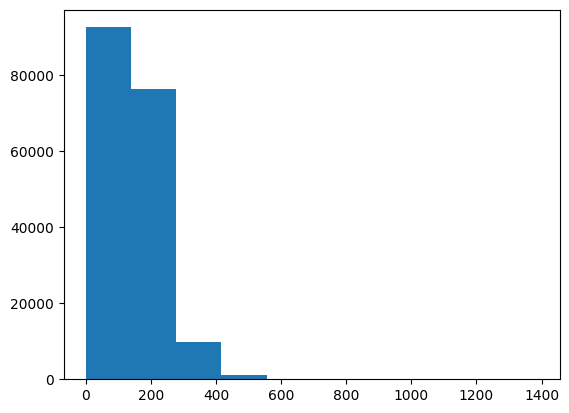

In [72]:
 plt.hist(characters_length, bins = 10)

In [73]:
output_seq_character_length = int(np.percentile(characters_length,95))
output_seq_character_length

290

In [74]:
alphabet = string.ascii_lowercase + string.digits +string.punctuation
print(alphabet)

abcdefghijklmnopqrstuvwxyz0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


creating character level token vectorizer


In [75]:
NUM_CHAR_TOKENS = len(alphabet) + 2
character_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                         output_sequence_length = output_seq_character_length,
                                         name = "character_tokenizer")

In [76]:
character_vectorizer.adapt(train_characters)

In [77]:
length_character_vocab = len(character_vectorizer.get_vocabulary())

In [78]:
print(length_character_vocab)

28


Creating Character level embedding layer

In [79]:
character_embedding = Embedding(input_dim = length_character_vocab,
                                mask_zero = "True",
                                output_dim = 25)

In [80]:
sen = train_sentences[0]
embedded_sen = character_embedding(character_vectorizer([sen]))
print(embedded_sen.shape)

(1, 290, 25)


In [81]:
input_data = Input(shape=(1,), dtype= tf.string)
vectors = character_vectorizer(input_data)
char_embed = character_embedding(vectors)
x = Conv1D(64, kernel_size= 5, activation= "relu", padding ="same")(char_embed)
x = GlobalMaxPool1D()(x)
output_data = Dense(len(classes), activation = "softmax")(x)
model_3 = Model(inputs = [input_data], outputs = [output_data], name = "model_3")

In [82]:
model_3.compile(loss = "categorical_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [83]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 character_tokenizer (TextV  (None, 290)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [84]:
train_dataset_2 = tf.data.Dataset.from_tensor_slices((train_characters,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset_2 = tf.data.Dataset.from_tensor_slices((validation_characters,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_2 = tf.data.Dataset.from_tensor_slices((test_characters,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [85]:
train_dataset_2

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [86]:
history_model_3 = model_3.fit(train_dataset_2,
                              epochs = 3,
                              steps_per_epoch = int(0.1*len(train_dataset_2)),
                              validation_data = val_dataset_2,
                              validation_steps = int(0.1*len(val_dataset_2)))

Epoch 1/3
562/562 [==============================] - 5s 6ms/step - loss: 1.2662 - accuracy: 0.4817 - val_loss: 1.0611 - val_accuracy: 0.5748
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0141 - accuracy: 0.5949 - val_loss: 0.9545 - val_accuracy: 0.6200
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9320 - accuracy: 0.6313 - val_loss: 0.8788 - val_accuracy: 0.6513


In [87]:
 model_3.evaluate(val_dataset_2)

945/945 [==============================] - 4s 4ms/step - loss: 0.8912 - accuracy: 0.6539


[0.8911970257759094, 0.6538792252540588]

In [88]:
model_3_predprob = model_3.predict(val_dataset_2)
model_3_predprob

945/945 [==============================] - 2s 2ms/step


array([[0.10282789, 0.48874038, 0.09769844, 0.15262744, 0.15810585],
       [0.11070193, 0.75540775, 0.02691524, 0.05531049, 0.05166456],
       [0.13030887, 0.3913418 , 0.23934439, 0.18603286, 0.05297201],
       ...,
       [0.01802662, 0.03727933, 0.13820179, 0.0429691 , 0.7635232 ],
       [0.04533171, 0.11691663, 0.187443  , 0.05444334, 0.5958653 ],
       [0.4704877 , 0.2758995 , 0.10748408, 0.13187657, 0.01425217]],
      dtype=float32)

In [89]:
model_3_preds = tf.argmax(model_3_predprob,axis =1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 4, 0])>

In [90]:
Results_model_3 = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_3_preds)
Results_model_3

{'accuracy': 65.38792532768436,
 'precision': 0.6448874469419418,
 'recall': 0.6538792532768436,
 'f1': 0.6440288668217851}

##Model 4 Using hybrid embedding layer (token + character)

In [91]:
input_token = Input(shape = [], dtype = tf.string)
token_embedding = tf_hub_embedding_layer(input_token)
output_token= Dense(128, activation= "relu")(token_embedding)
sub_model_1 = Model(inputs = [input_token],
                     outputs = [output_token])
input_char = Input(shape=(1,), dtype= tf.string)
vectors = character_vectorizer(input_char)
char_embed = character_embedding(vectors)
bidirectional_lstm = Bidirectional(LSTM(25))(char_embed)
sub_model_2 = Model(inputs = [input_char],
                    outputs = [bidirectional_lstm], name = "sub_model_2")
#creating a hybrid embedding
hybrid_embedding= Concatenate(name= "hybrid_embedding")([sub_model_1.output,sub_model_2.output])
x = Dropout(0.5)(hybrid_embedding)
x = Dense(128, activation = "relu")(x)
x = Dropout(0.5)(x)
output = Dense(len(classes), activation = "softmax")(x)
Hybrid_model = Model(inputs = [sub_model_1.input, sub_model_2.input],
                     outputs = [output], name = "Hybrid_model")
Hybrid_model.summary()

Model: "Hybrid_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 character_tokenizer (TextV  (None, 290)                  0         ['input_5[0][0]']             
 ectorization)                                                                                    
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['input_4[0][0]']  

In [92]:
Hybrid_model.compile(loss = "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

### Multi input fast loading tf.dataset

In [93]:
# for training dataset
train_hybrid_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_characters))
train_hybrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_hybrid_dataset = tf.data.Dataset.zip((train_hybrid_data, train_hybrid_labels))
train_hybrid_dataset = train_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
# for validation dataset
validation_hybrid_data = tf.data.Dataset.from_tensor_slices((validation_sentences, validation_characters))
validation_hybrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
validation_hybrid_dataset = tf.data.Dataset.zip((validation_hybrid_data, validation_hybrid_labels))
validation_hybrid_dataset = validation_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
# for test dataset
test_hybrid_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_characters))
test_hybrid_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_hybrid_dataset = tf.data.Dataset.zip((test_hybrid_data, test_hybrid_labels))
test_hybrid_dataset = test_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [94]:
train_hybrid_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Training the Hybrid model

In [95]:
history_hybrid_model = Hybrid_model.fit(train_hybrid_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1*len(train_hybrid_dataset)),
                              validation_data = validation_hybrid_dataset,
                              validation_steps = int(0.1*len(validation_hybrid_dataset)))

Epoch 1/3
562/562 [==============================] - 42s 53ms/step - loss: 0.9844 - accuracy: 0.6085 - val_loss: 0.7812 - val_accuracy: 0.6991
Epoch 2/3
562/562 [==============================] - 28s 49ms/step - loss: 0.8034 - accuracy: 0.6903 - val_loss: 0.7213 - val_accuracy: 0.7224
Epoch 3/3
562/562 [==============================] - 23s 42ms/step - loss: 0.7756 - accuracy: 0.7040 - val_loss: 0.6885 - val_accuracy: 0.7397


In [96]:
Hybrid_model.evaluate(validation_hybrid_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.6939 - accuracy: 0.7342


[0.6938584446907043, 0.7341784834861755]

In [97]:
Hybrid_model_predprobs = Hybrid_model.predict(validation_hybrid_dataset)
Hybrid_model_predprobs

945/945 [==============================] - 23s 20ms/step


array([[4.4342402e-01, 3.1725669e-01, 3.9014260e-03, 2.2859836e-01,
        6.8194577e-03],
       [3.1382138e-01, 4.6841422e-01, 3.2319608e-03, 2.1211219e-01,
        2.4203197e-03],
       [2.5550956e-01, 1.6442287e-01, 5.0147630e-02, 4.9255416e-01,
        3.7365701e-02],
       ...,
       [6.2538974e-04, 8.2740886e-03, 4.3945324e-02, 1.3431054e-04,
        9.4702089e-01],
       [1.2045966e-02, 7.8527510e-02, 2.9417959e-01, 5.0675985e-03,
        6.1017931e-01],
       [3.1071585e-01, 3.8007742e-01, 2.1222883e-01, 3.0197721e-02,
        6.6780262e-02]], dtype=float32)

In [98]:
Hybrid_model_preds = tf.argmax(Hybrid_model_predprobs, axis = 1)
Hybrid_model_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [99]:
Results_Hybrid_model = calculate_results(y_true = val_labels_encoded,
                                         y_pred = Hybrid_model_preds)
print(Results_Hybrid_model)

{'accuracy': 73.41784721302793, 'precision': 0.7341744062132162, 'recall': 0.7341784721302793, 'f1': 0.7306656117391724}


In [100]:
print(Results_model_1)

{'accuracy': 78.58797828677346, 'precision': 0.7824102389993751, 'recall': 0.7858797828677346, 'f1': 0.7833405361137926}


## Positional embeddings


In [101]:
 train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


<Axes: ylabel='Frequency'>

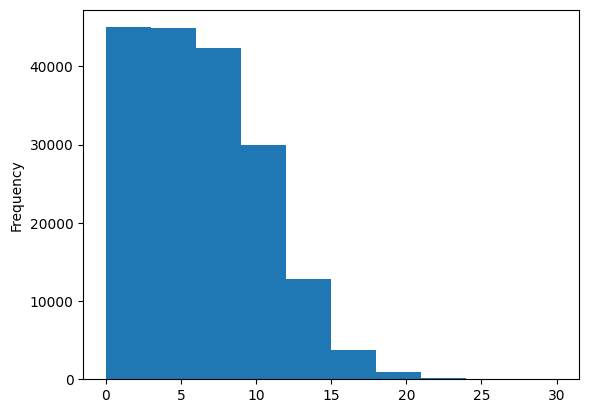

In [102]:
train_df.line_number.plot.hist()

In [103]:
train_ln_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth = 15)
val_ln_one_hot = tf.one_hot(validation_df["line_number"].to_numpy(), depth = 15)
test_ln_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth = 15)

In [104]:
train_ln_one_hot.shape

TensorShape([180040, 15])

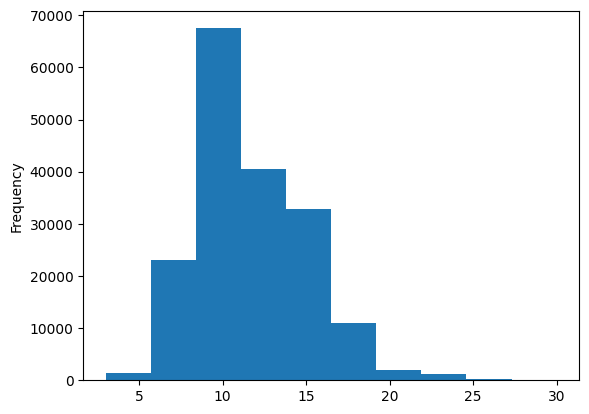

In [105]:
train_df.total_lines.plot.hist();

In [106]:
np.percentile(train_df.total_lines, 98)

20.0

In [107]:
train_total_ln_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth = 20)
val_total_ln_one_hot = tf.one_hot(validation_df["total_lines"].to_numpy(), depth = 20)
test_total_ln_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth = 20)

In [108]:
train_total_ln_one_hot.shape

TensorShape([180040, 20])

##Building Tribrid embedding model

In [109]:
input_token = Input(shape = [], dtype = "string", name = "inputs_token")
token_embedding = tf_hub_embedding_layer(input_token)
output_token= Dense(128, activation= "relu")(token_embedding)
sub_model_1 = Model(inputs = [input_token],
                     outputs = [output_token])
input_char = Input(shape=(1,), dtype= tf.string)
vectors = character_vectorizer(input_char)
char_embed = character_embedding(vectors)
bidirectional_lstm = Bidirectional(LSTM(25))(char_embed)
sub_model_2 = Model(inputs = [input_char],
                    outputs = [bidirectional_lstm], name = "sub_model_2")
input_ln = Input(shape=(15,), dtype=tf.int32, name="input_ln")
z = Dense(32, activation="relu")(input_ln)
ln_feature_model = Model(inputs=[input_ln],
                                   outputs=[z])
input_total_line = Input(shape=(20,), dtype=tf.int32, name="input_total_line")
y = Dense(32, activation="relu")(input_total_line)
total_line_feature_model = tf.keras.Model(inputs=[input_total_line],
                                  outputs=[y])
token_char_embeddings = Concatenate(name="token_char_embeddings")([sub_model_1.output,
                                                                              sub_model_2.output])
x = Dense(256, activation="relu")(token_char_embeddings)
x = Dropout(0.5)(x)
x = Concatenate(name="token_char_positional_embedding")([ln_feature_model.output,
                                                                total_line_feature_model.output,
                                                                x])
output = Dense(5, activation="softmax", name="output")(x)
Tribid_model = Model(inputs=[ln_feature_model.input,
                        total_line_feature_model.input,
                        sub_model_1.input,
                        sub_model_2.input],
                outputs = [output], name ="Tribid_model")
print(Tribid_model.summary())

Model: "Tribid_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 inputs_token (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 character_tokenizer (TextV  (None, 290)                  0         ['input_6[0][0]']             
 ectorization)                                                                                    
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['inputs_token[0][0

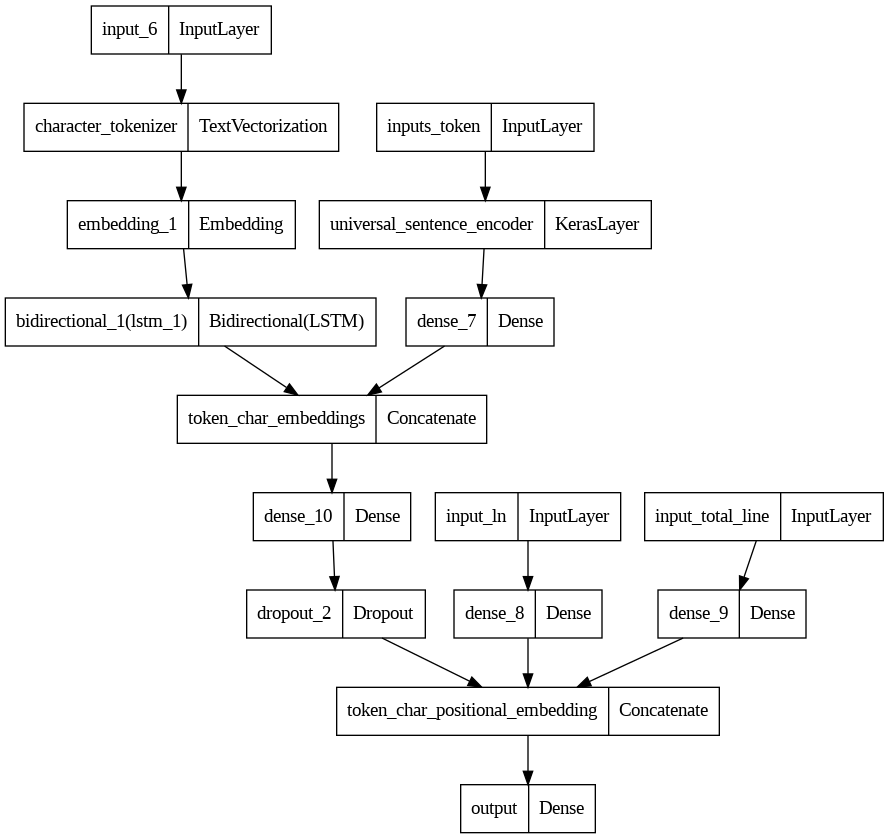

In [110]:
plot_model(Tribid_model)

In [111]:
Tribid_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [112]:
#training dataset
train_tribid_data = tf.data.Dataset.from_tensor_slices((train_ln_one_hot, train_total_ln_one_hot, train_sentences, train_characters))
train_tribid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tribid_dataset = tf.data.Dataset.zip((train_tribid_data, train_tribid_labels))
train_tribid_dataset = train_tribid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
# Validation dataset
val_tribid_data = tf.data.Dataset.from_tensor_slices((val_ln_one_hot, val_total_ln_one_hot, validation_sentences, validation_characters))
val_tribid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tribid_dataset = tf.data.Dataset.zip((val_tribid_data, val_tribid_labels))
val_tribid_dataset = val_tribid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [113]:
train_tribid_dataset, val_tribid_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [114]:
history_Tribid_model = Tribid_model.fit(train_tribid_dataset,
                              steps_per_epoch=int(0.1 * len(train_tribid_dataset)),
                              epochs=3,
                              validation_data=val_tribid_dataset,
                              validation_steps=int(0.1 * len(val_tribid_dataset)))

Epoch 1/3
562/562 [==============================] - 42s 54ms/step - loss: 1.0898 - accuracy: 0.7308 - val_loss: 0.9785 - val_accuracy: 0.8045
Epoch 2/3
562/562 [==============================] - 28s 49ms/step - loss: 0.9636 - accuracy: 0.8173 - val_loss: 0.9490 - val_accuracy: 0.8278
Epoch 3/3
562/562 [==============================] - 28s 50ms/step - loss: 0.9474 - accuracy: 0.8263 - val_loss: 0.9372 - val_accuracy: 0.8354


In [115]:
Tribid_model_predprobs = Tribid_model.predict(val_tribid_dataset, verbose=1)
Tribid_model_predprobs

945/945 [==============================] - 21s 20ms/step


array([[0.5079155 , 0.12471359, 0.0115228 , 0.33710137, 0.01874676],
       [0.4934492 , 0.09863961, 0.0432223 , 0.3523115 , 0.01237739],
       [0.2922666 , 0.10335478, 0.13651896, 0.3983179 , 0.06954167],
       ...,
       [0.03468942, 0.10323936, 0.03650421, 0.02982136, 0.79574573],
       [0.03212022, 0.27028567, 0.07594233, 0.02660785, 0.59504396],
       [0.20064594, 0.6062836 , 0.09091143, 0.04456639, 0.05759262]],
      dtype=float32)

In [116]:
Tribid_model_preds = tf.argmax(Tribid_model_predprobs, axis=1)
Tribid_model_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [117]:
Results_Tribid_model = calculate_results(y_true=val_labels_encoded,
                                    y_pred=Tribid_model_preds)
Results_Tribid_model

{'accuracy': 83.49331391500067,
 'precision': 0.8342835943722685,
 'recall': 0.8349331391500067,
 'f1': 0.8341655097052713}

In [118]:
all_model_results = pd.DataFrame({"baseline": base_model_results,
                                  "token_embed_conv1d": Results_model_1,
                                  "pretrained_token_embed": Results_model_2,
                                  "char_embed_conv1d": Results_model_3,
                                  "hybrid_embed": Results_Hybrid_model,
                                  "tribrid_embed":Results_Tribid_model })
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
token_embed_conv1d,78.587978,0.782410,0.785880,0.783341
pretrained_token_embed,71.286244,0.713039,0.712862,0.710037
char_embed_conv1d,65.387925,0.644887,0.653879,0.644029
hybrid_embed,73.417847,0.734174,0.734178,0.730666
tribrid_embed,83.493314,0.834284,0.834933,0.834166


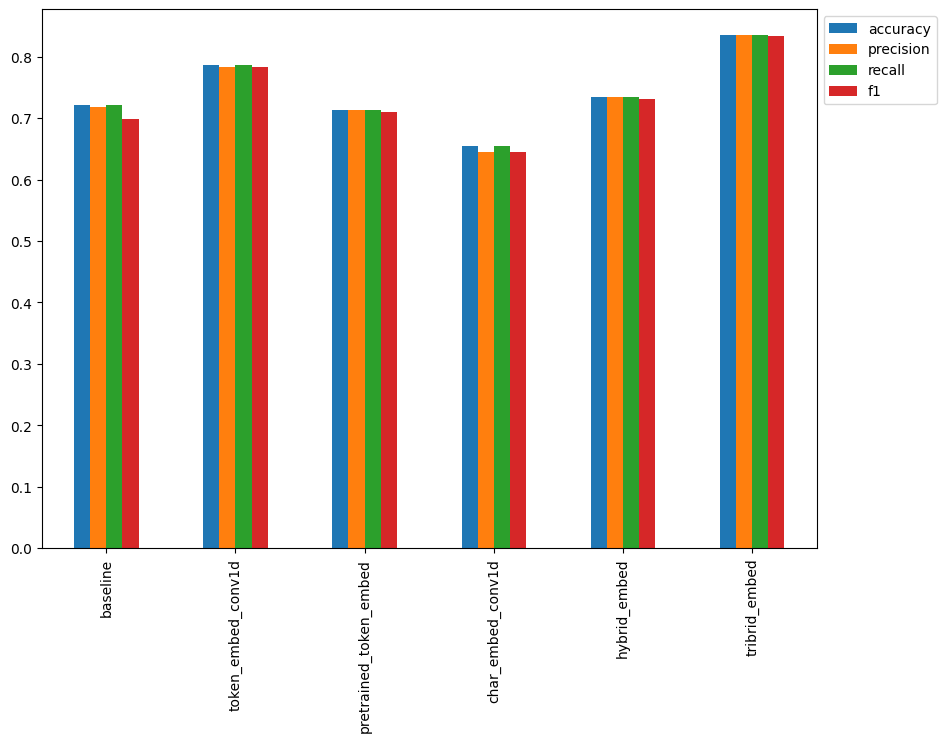

In [119]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

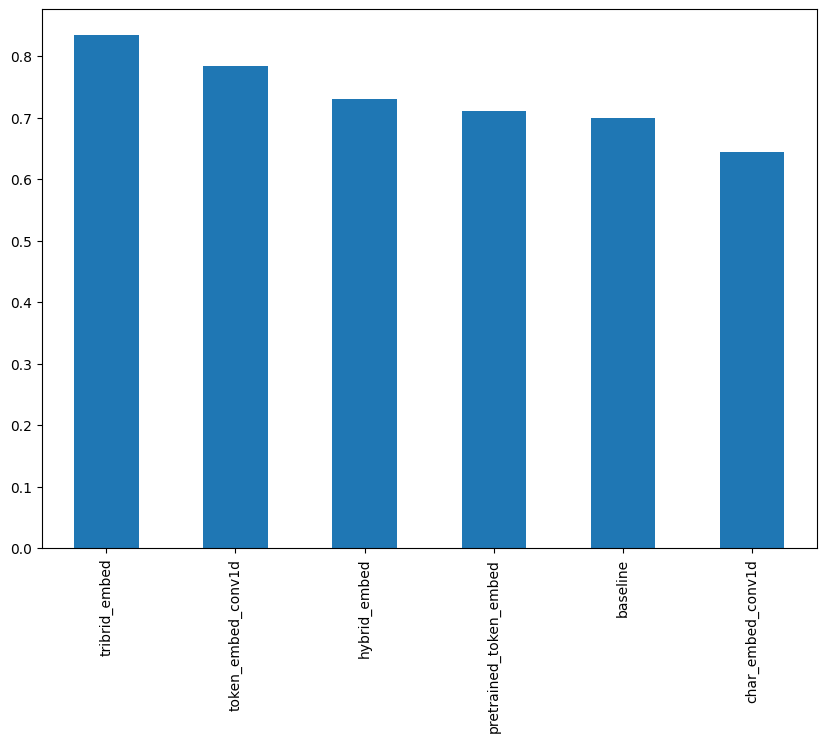

In [120]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Save and load best performing model

In [121]:
Tribid_model.save("Tribid_Model")

In [122]:
loaded_model = tf.keras.models.load_model("/content/Tribid_Model")

In [123]:
loaded_predprobs = loaded_model.predict(val_tribid_dataset)
loaded_preds = tf.argmax(loaded_predprobs, axis = 1)
loaded_preds[:10]

945/945 [==============================] - 23s 21ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [124]:
loaded_model_results = calculate_results(y_true= val_labels_encoded,
                                         y_pred= loaded_preds)
loaded_model_results

{'accuracy': 83.49331391500067,
 'precision': 0.8342835943722685,
 'recall': 0.8349331391500067,
 'f1': 0.8341655097052713}

In [125]:
loaded_model.summary()

Model: "Tribid_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 inputs_token (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 character_tokenizer (TextV  (None, 290)                  0         ['input_6[0][0]']             
 ectorization)                                                                                    
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['inputs_token[0][0

## Evaluating best model on test data

In [126]:
test_tribid_data = tf.data.Dataset.from_tensor_slices((test_ln_one_hot, test_total_ln_one_hot, test_sentences, test_characters))
test_tribid_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_tribid_dataset = tf.data.Dataset.zip((test_tribid_data, test_tribid_labels))
test_tribid_dataset = test_tribid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [127]:
loaded_predprobs_test = loaded_model.predict(test_tribid_dataset)
loaded_preds_test = tf.argmax(loaded_predprobs_test, axis = 1)
loaded_preds_test[:10]


942/942 [==============================] - 19s 20ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 4, 0])>

In [128]:
loaded_model_results_test = calculate_results(y_true= test_labels_encoded,
                                              y_pred= loaded_preds_test)
loaded_model_results_test

{'accuracy': 82.89696366351419,
 'precision': 0.8279822560032326,
 'recall': 0.8289696366351419,
 'f1': 0.8281007521925303}